In [2]:
import glob 

import xarray
import pandas as pd
import numpy as np

import datetime

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

from scipy.interpolate import RegularGridInterpolator


# Open the model file here.

In [3]:
file_pattern = '/home/svisaga/MUSICA_ANALYSES/curtain_tracks/p3_2019-*curtain*.nc'
file_list = glob.glob(file_pattern)

ds_mod = xarray.open_mfdataset(file_list,combine='by_coords')


In [4]:
ds_mod['datetime'].values

array(['2019-08-24 22:11:08', '2019-08-24 22:11:09',
       '2019-08-24 22:11:10', ..., '2019-10-05 07:29:22',
       '2019-10-05 07:29:23', '2019-10-05 07:29:24'], dtype=object)

In [5]:
ds_mod['datetime'] = pd.to_datetime(ds_mod['datetime'].values)


In [6]:
variables = ['alt_mod', 'EXTINCT_mod', 'pblh_mod']
ds_mod_ = ds_mod[variables]
df_mod = ds_mod_.to_dataframe().reset_index()
df_mod['datetime'] = pd.to_datetime(df_mod['datetime'])


startdate_ = '2019-10-04 00:37:00'
enddate_ = '2019-10-04 00:48:00'
df_mod = df_mod[(df_mod['datetime'] >= startdate_) & (df_mod['datetime'] < enddate_)]



In [7]:
lev= 30
df_mod_alt_lev30 = df_mod.loc[df_mod['nl'] == (31 - lev), ['datetime', 'alt_mod']]
#df_mod_alt_lev30
ds_mod_alt_lev30 = df_mod_alt_lev30.set_index(['datetime']).to_xarray()


In [8]:
lev = 29
df_mod_alt_lev29 = df_mod.loc[df_mod['nl'] == (31 - lev), ['datetime', 'alt_mod']]
#df_mod_alt_lev29
ds_mod_alt_lev29 = df_mod_alt_lev29.set_index(['datetime']).to_xarray()

In [9]:
# We will use later for making xarray
df_mod_pblh = df_mod[['datetime','pblh_mod']].drop_duplicates()

# Open HSRL file.

In [10]:
dat = '20191003'
base_date = pd.Timestamp('2019-10-03')
ds = xarray.open_dataset(f'/home/svisaga/MUSICA_ANALYSES/curtain_tracks/hsrl_{dat}_curtain_CAMP2Ex.nc')
ds = ds.assign_coords(Date=pd.to_datetime(ds['Date'].values))
ds

<xarray.Dataset>
Dimensions:       (Date: 1230, Altitude: 450)
Coordinates:
  * Date          (Date) datetime64[ns] 2019-10-03T22:58:39 ... 2019-10-04T02...
  * Altitude      (Altitude) float64 -500.0 -485.0 -470.0 ... 6.215e+03 6.23e+03
Data variables:
    hsrl_532_ext  (Date, Altitude) float64 ...

In [11]:
kk = 590
ee = 660

# pblh xarray

In [12]:
ds_mod_pblh_interp = df_mod_pblh.set_index(['datetime']).to_xarray()



# Start interpolating MUSICAv0 Extinction to HSRL altitude values.

In [13]:
constant_altitudes = ds.Altitude.values

# Create an empty DataFrame to store the resampled data
df_mod_interp = []

# Group the data by datetime
grouped = df_mod.groupby('datetime')

for name, group in grouped:
    # Sort by altitude to ensure monotonic input for interpolation
    group_sorted = group.sort_values('alt_mod')

    # Get min and max altitude for this group
    min_alt = group_sorted['alt_mod'].min()
    max_alt = group_sorted['alt_mod'].max()

    # Clip constant_altitudes to the valid range
    valid_altitudes = constant_altitudes[
        (constant_altitudes >= min_alt) & (constant_altitudes <= max_alt)
    ]

    # Interpolate only within the valid range
    interpolated = np.interp(valid_altitudes, group_sorted['alt_mod'], group_sorted['EXTINCT_mod'])

    # Create a DataFrame for the interpolated data
    interpolated_df = pd.DataFrame({
        'datetime': name,
        'altitude': valid_altitudes,
        'EXTINCT_mod': interpolated
    })

    df_mod_interp.append(interpolated_df)

df_mod_interp = pd.concat(df_mod_interp, ignore_index=True)
df_mod_interp


,datetime,altitude,EXTINCT_mod
0,2019-10-04 00:37:00,579.252849,0.000072
1,2019-10-04 00:37:00,594.242472,0.000069
2,2019-10-04 00:37:00,609.232095,0.000066
3,2019-10-04 00:37:00,624.221717,0.000063
4,2019-10-04 00:37:00,639.211340,0.000060
...,...,...,...
262985,2019-10-04 00:47:59,6170.382190,0.000002
262986,2019-10-04 00:47:59,6185.371813,0.000002
262987,2019-10-04 00:47:59,6200.361436,0.000002
262988,2019-10-04 00:47:59,6215.351059,0.000002


# Make df_mod interpolated to HSRL altitude to a Data Array.

In [14]:
ds_mod_interp = df_mod_interp.set_index(['datetime', 'altitude']).to_xarray()
ds_mod_interp


<xarray.Dataset>
Dimensions:      (datetime: 660, altitude: 412)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2019-10-04T00:37:00 ... 2019-10-04...
  * altitude     (altitude) float64 69.61 84.6 99.58 ... 6.215e+03 6.23e+03
Data variables:
    EXTINCT_mod  (datetime, altitude) float64 nan nan ... 2.205e-06 2.204e-06

# Visualize the interpolated Extinction.

In [15]:
curt_time = ds_mod_interp['datetime']
curt_time_np = np.array(curt_time, dtype='datetime64')

# Create a 2D array by repeating curt_time_np along the second axis
curt_time2 = np.tile(curt_time_np[:, np.newaxis], (1, ds_mod_interp['EXTINCT_mod'].shape[1]))


In [16]:
filedate_ = '1004_0036'
ds_mod_interp_ = ds_mod_interp.sel(datetime=slice(startdate_, enddate_))
ds_mod_interp_

ds_mod_alt_lev29_ = ds_mod_alt_lev29.sel(datetime=slice(startdate_, enddate_))
ds_mod_alt_lev30_ = ds_mod_alt_lev30.sel(datetime=slice(startdate_, enddate_))
ds_mod_pblh_interp_ = ds_mod_pblh_interp.sel(datetime=slice(startdate_, enddate_))

# Use longitude values for x-axis.

In [17]:
ds_nav = xarray.open_dataset(f'/home/svisaga/MUSICA_ANALYSES/WWW-AIR_1726704979598/CAMP2EX-HSRL2_P3B_{dat}_R0.h5', engine='h5netcdf', 
                             phony_dims='access', group='Nav_Data')

base_jday = ds_nav['Jday'][:,0].values[0]

# Calculate the difference in days from the base Julian Day
day_deltas = ds_nav['Jday'][:,0].values - base_jday

# Convert GPS times in hours to timedeltas
time_deltas = pd.to_timedelta(ds_nav['gps_time'][:,0].values, unit='h')

# Create datetime objects by adding the day deltas to the base date
dates = base_date + pd.to_timedelta(day_deltas, unit='D')

# Add the time deltas to the dates
date_times = dates + time_deltas

# Format the dates to YY-MM-DD
formatted_dates = date_times.strftime('%Y-%m-%d %H:%M:%S')


# Create a new xarray DataArray
ds_nav['Date'] = xarray.DataArray(
    formatted_dates,
    dims=["time"]
)



In [18]:
df_nav = ds_nav['Date'].to_dataframe().reset_index()
df_nav['time'] = pd.to_datetime(df_nav['time'])

In [19]:
dat = '20191003'
dat1 = '2019-10-03-03600'
dat2 = '2019-10-04-03600'
workdir = '/home/svisaga/MUSICA_ANALYSES/WWW-AIR_1726704979598/'
p3file = f'CAMP2Ex-mrg01-P3B-NC_merge_{dat}_R3.nc'
p3data_ds = xarray.open_dataset(workdir+p3file)

variables = ['AOT532_hi']
selected_data = p3data_ds[variables]
p3data = selected_data.to_dataframe().reset_index()
p3data['time'] = pd.to_datetime(p3data['time'].dt.strftime("%Y-%m-%d %H:%M:%S"))

In [20]:
df_nav_ = pd.merge(df_nav, p3data, on='time', how='inner')
df_nav_

,time,Date,AOT532_hi,lat,lon,alt
0,2019-10-03 22:58:39,2019-10-03 22:58:39,NaN,15.322504,120.646095,1200.199951
1,2019-10-03 22:58:49,2019-10-03 22:58:49,NaN,15.319890,120.657173,1277.800049
2,2019-10-03 22:58:59,2019-10-03 22:58:59,NaN,15.316633,120.668106,1360.800049
3,2019-10-03 22:59:09,2019-10-03 22:59:09,NaN,15.312698,120.678810,1451.099976
4,2019-10-03 22:59:19,2019-10-03 22:59:19,NaN,15.308269,120.689278,1535.500000
...,...,...,...,...,...,...
1225,2019-10-04 02:22:49,2019-10-04 02:22:49,NaN,14.147677,120.598465,1126.800049
1226,2019-10-04 02:22:59,2019-10-04 02:22:59,NaN,14.153267,120.607849,1130.099976
1227,2019-10-04 02:23:09,2019-10-04 02:23:09,NaN,14.158759,120.617142,1131.500000
1228,2019-10-04 02:23:20,2019-10-04 02:23:20,NaN,14.164734,120.627274,1132.500000


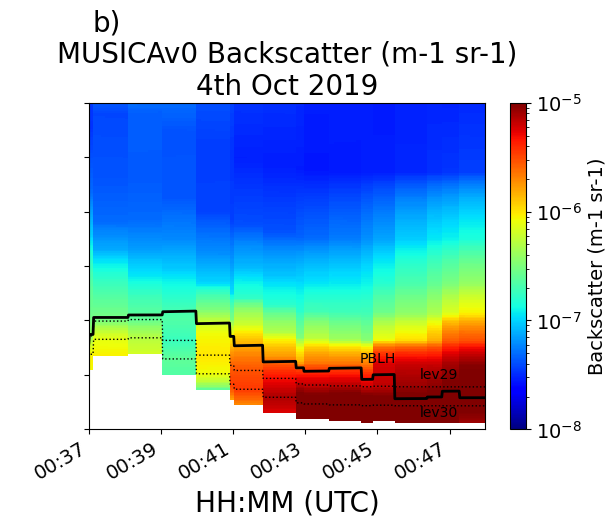

In [29]:
fig, ax = plt.subplots()
ax.text(0.01, 1.2, f'b)', transform=ax.transAxes,
            fontsize=20,  va='bottom', ha='left')


c = ax.pcolormesh(ds_mod_interp_['datetime'],ds_mod_interp_['altitude']/1000,(ds_mod_interp_['EXTINCT_mod']/64.65).T,norm=mcolors.LogNorm(vmin=1E-8, vmax=1E-5),cmap='jet')
# Plot MLH on top
ax.plot(ds_mod_pblh_interp_['datetime'], ds_mod_pblh_interp_['pblh_mod']/1000, color='black', linewidth=2, label='MLH')
ax.plot(ds_mod_alt_lev29_['datetime'], ds_mod_alt_lev29_['alt_mod']/1000, color='black', linestyle=':', linewidth=1, label='lev29')
ax.plot(ds_mod_alt_lev30_['datetime'], ds_mod_alt_lev30_['alt_mod']/1000, color='black', linestyle=':', linewidth=1, label='lev30')
ax.set_ylim(0,3)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=16, color='white')

ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

fig.autofmt_xdate()
for label in ax.xaxis.get_majorticklabels():
    label.set_horizontalalignment('right')
    #label.set_x(label.get_position()[0] - 2)  # Adjust the value as needed
x_last = ds_mod_alt_lev29_['datetime'].values[550]
ax.text(x_last, 0.5, 'lev29', color='k', fontsize=10, ha='left', va='center')
x_last = ds_mod_alt_lev29_['datetime'].values[450]
ax.text(x_last, 0.65, 'PBLH', color='k', fontsize=10, ha='left', va='center')
x_last = ds_mod_alt_lev30_['datetime'].values[550]
ax.text(x_last, 0.15, 'lev30', color='k', fontsize=10, ha='left', va='center')


cbar = plt.colorbar(c)
cbar.set_label('Backscatter (m-1 sr-1)', fontsize=14)
cbar.ax.tick_params(labelsize=14)      

plt.title(f'MUSICAv0 Backscatter (m-1 sr-1)\n4th Oct 2019', fontsize=20)
plt.ylabel('Altitude (km)',fontsize=20, color='white')
plt.xlabel('HH:MM (UTC)',fontsize=20)
plt.savefig(f'img/Figure14b_AMSPaper.png',dpi=300, bbox_inches='tight')